In [1]:
import sys
import os
import pickle
# from scipy.misc import imread
from matplotlib.pyplot import imread  
import numpy as np
import matplotlib.pyplot as plt
import math

# example methods to calculate epipolar distance and sfm

In [2]:
def point_from_epipolar(known_point,unknown_point,foe,debug=False):
# define a line known_point<--->foe and get the distance
    line=np.cross(known_point,foe)
    line=line/(np.linalg.norm(line[:2]))
    d=unknown_point.dot(line)
    if debug:
        print(line, d) 
        t=np.arange(0,2*np.pi,0.01)
        s=np.sin(t)
        c=np.cos(t)
        plt.figure("epi")
        plt.plot(known_point[0],known_point[1],"+r",markersize=5)
        plt.plot(foe[0],foe[1],"+b",markersize=5)
        plt.plot(unknown_point[0],unknown_point[1],".b",markersize=5)
        plt.plot(t,-(t*line[0]+line[2])/line[1])
        plt.plot(d*s+unknown_point[0],d*c+unknown_point[1],'k')
    return np.abs(d)


def ZfromTracking(pcurr,pprev,RcFp,TcFp):
    pfoe=TcFp/TcFp[2]
    prot = RcFp.dot(pprev)
    prot = prot/prot[2,:] # normalized
    d = pcurr-prot
    n = pfoe-prot
    Zx = TcFp[2] *n[0,:]/d[0,:]
    Zy = TcFp[2] *n[1,:]/d[1,:]
    return Zx, Zy

# load data for the sequence from pickle

In [3]:
with open('data4lesson/data.pkl', 'rb') as pklfile:
    data = pickle.load(pklfile, fix_imports=True,encoding="latin1")
focal_length = data['flx']
pp = data['principle_point']
EM = data['egomotion_18-19']
point_18 = data['points_18']
point_19 = data['points_19']
points_18 = data['points_18'][0] - pp #extract the labels and substarct the pp
points_19 = data['points_19'][0] - pp 
R = EM[:3, :3]
t = EM[:3, 3]
foe = EM[:3, 3] / EM[2, 3]
foe[:2] *= focal_length

# visualize the data

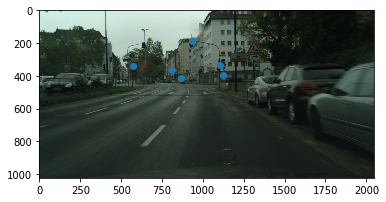

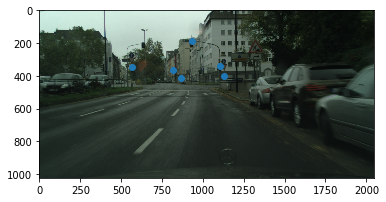

In [4]:
with open('data4lesson/dusseldorf_000049_000018_leftImg8bit.png', 'rb') as imgfile:
    img1 = imread(imgfile)
with open('data4lesson/dusseldorf_000049_000019_leftImg8bit.png', 'rb') as imgfile:
    img2 = imread(imgfile)

plt.figure('frame 18')
plt.imshow(img1)
plt.scatter(point_18[0][:, 0], point_18[0][:, 1])
plt.figure('frame 19')
plt.imshow(img2)
plt.scatter(point_19[0][:, 0], point_19[0][:, 1])
plt.show()

# find match for the first point

In [5]:
idx = 0
possible_matches = []
color = points_18[1][idx]
point = points_18[0][idx]
#creating homogonize vector and substracting the principle point to have the point in sfm coordinate system
pt1 = np.ones(3)
pt1[0] = point[0] - pp[0]
pt1[1] = point[1] - pp[1]
for jdx, point1 in enumerate(points_19[0]):
    if color == points_19[1][jdx]: # only matching if same color
        pt2 = np.ones(3)
        pt2[0] = point1[0] - pp[0]
        pt2[1] = point1[1] - pp[1]
        epipolar_distance = point_from_epipolar(pt2, pt1, foe)
        possible_matches.append((epipolar_distance, jdx))
possible_matches = sorted(possible_matches, key=lambda x: x[0])
# choosing the point with the same color and lowest epipolar distance as match
point1 = points_19[0][possible_matches[0][1]]
pt2 = np.ones(3)
pt2[0] = point1[0] - pp[0]
pt2[1] = point1[1] - pp[1]
pt2[:2] /= focal_length
pt1[:2] /= focal_length
#calculating depth from sfm
zx, zy = ZfromTracking(pt2[:, np.newaxis], pt1[:, np.newaxis], EM[:3, :3], EM[:3, 3][:, np.newaxis])
print(zx, zy)

IndexError: invalid index to scalar variable.

# Rotate previous points

In [6]:
def rotate_prev_points(points, R):
    rotate_points = []
    for p in points:
        prev = np.append(p ,focal_length)
        rotate_prev = np.matmul(R,prev)
        rotate_points.append(list(rotate_prev))
    return rotate_points
prev_points = rotate_prev_points(points_18,R)
print(prev_points)

[[-525.1989312807751, -168.49241786330884, 2264.523067387163], [-163.22259145715168, -322.54798024103036, 2264.4085755677797], [6.79997586137541, -174.5742169132034, 2264.1053116279472], [-281.6955723181236, -146.02987432474384, 2264.303268196538], [-229.68855787486234, -100.03790013597998, 2264.209679102668], [28.809293130265864, -113.57763956836584, 2264.0186769202833]]


# Compute epipolar lines for lights in current image

In [7]:
def compute_epipolar_lines(current_point, foe):
    ex, ey = foe[:2]
    dx, dy = current_point[:2] 
    m = (ey - dy)/(ex - dx)
    n = (dy*ex - ey*dx)/(ex - dx)
    return m,n


In [8]:
m,n = compute_epipolar_lines(points_19[0],foe)
print(m,n,points_19[0])

0.1936703263553809 -67.3019301118198 [-530.98  -170.137]


# Distance of point from line

In [9]:
def calc_distance_points_from_line(m, n, point):
    x, y = point[:2]
    d = abs((m*x + n -y)/math.sqrt(m**2 + 1))
    return d
calc_distance_points_from_line(m, n,prev_points[0])

0.5153840812872366

# match points

In [10]:
def match_between_points(prev_points,current_points,foe):
    prev_points = rotate_prev_points(prev_points,R)
    matches = []
    for prev in prev_points:
        distance = []
        for cur in current_points:
            m, n = compute_epipolar_lines(cur,foe)
            d = calc_distance_points_from_line(m,n,prev)
            distance.append(d)
        min_distance = np.argmin(np.array(distance))
        matches.append((prev[:2], current_points[min_distance]))
    return matches               
matches = match_between_points(points_18,points_19,foe) 


# color the matches points

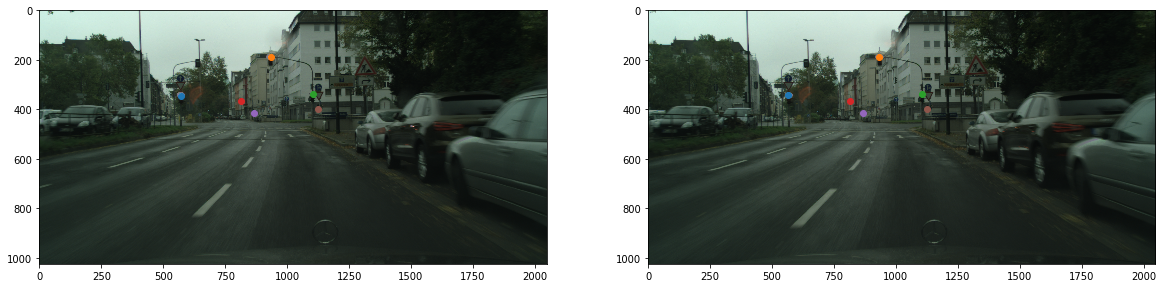

In [11]:
def color_matches(matches, img_18, img_19):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
    ax1.imshow(img1)
    ax2.imshow(img2)
    for match in matches:
        x_prev, y_prev = match[0] + pp
        x_current, y_current = match[1] + pp
        ax1.scatter(x_prev,y_prev)
        ax2.scatter(x_current, y_current)
    plt.show()
    
color_matches(matches,img1,img2)

# Calculate Z depth from tracking

In [12]:
def calc_sfm(matches, foe):
    depth = []
    for match in matches:
        prev= match[0]
        current= match[1]
        e = foe[:2]
        tz = t[2]
        Z = tz*((e - prev)/(current - prev))
        depth.append((Z,current))
    return depth
depth = calc_sfm(matches, foe)


[-7.62475154 -2.44312847]
[-4.05146515 -7.98449039]
[ 0.11316887 -2.83949068]
[-46.90738403 -24.26686626]
[-13.59469992  -5.91935153]
[ 0.49451801 -1.91201903]


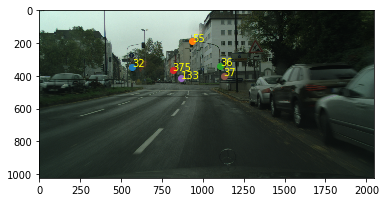

In [13]:
def calc_depth(depth):
    
    plt.imshow(img2)

    for d in depth:
        Zx, Zy = d[0]
        current_point = d[1] + pp
#         max_value = max(d[0])
#         min_value = min(d[0])
#         weight = min_value/max_value
#         avg = max_value*weight + (1-weight)*min_value
        real_point =d[1] * (Zy/focal_length)
        plt.scatter(current_point[0],current_point[1])
        plt.annotate(int(Zy),(current_point[0],current_point[1]),color='yellow')
        print(real_point)
    plt.show()
        
calc_depth(depth)           